In [2]:
import pandas as pd
import numpy as np
import nltk 
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')
import codecs
from sklearn.model_selection import train_test_split
import unidecode
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\masou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('./patagonia.csv', sep=';',header=0, encoding= 'latin1')

In [4]:
data.head()

,texto,fecha,fuente,tipo_de_fuente,sentimiento,genero,ubicación,pais
0,Me traje la birra al baño xq ni pinta q se cal...,2020-01-01 00:27,twitter,tweet,Positive,female,"La Pampa, Argentina",Argentina
1,"Por un 2020 con salud, con trabajo, con mi fam...",2020-01-01 01:43,twitter,tweet,Positive,female,"Cordoba, Argentina",Argentina
2,(Cesar Salvatierra http://www.facebook.com/235...,2020-01-01 05:32,facebook,fb-comment,Positive,male,Unrecognized,Unrecognized
3,@pablo_e_ordonez,2020-01-01 10:37,instagramComment,ig-comment,Positive,male,Unrecognized,Unrecognized
4,@fascarza Y viajar a la Patagonia a comer cord...,2020-01-01 13:54,twitter,tweet,Positive,male,Paraguay,Paraguay


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19322 entries, 0 to 19321
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   texto           19322 non-null  object
 1   fecha           19322 non-null  object
 2   fuente          19322 non-null  object
 3   tipo_de_fuente  19322 non-null  object
 4   sentimiento     18558 non-null  object
 5   genero          19322 non-null  object
 6   ubicación       19322 non-null  object
 7   pais            19322 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


In [6]:
data.dtypes

texto             object
fecha             object
fuente            object
tipo_de_fuente    object
sentimiento       object
genero            object
ubicación         object
pais              object
dtype: object

In [7]:
data.describe()

,texto,fecha,fuente,tipo_de_fuente,sentimiento,genero,ubicación,pais
count,19322,19322,19322,19322,18558,19322,19322,19322
unique,16236,17099,3,6,3,3,590,27
top,"Gente mi tío vende, entre otras cosas, el pack...",2020-07-04 13:33,facebook,fb-comment,Positive,male,Unrecognized,Unrecognized
freq,688,8,8717,8705,13247,8699,14464,14464


In [8]:
#Se encuentran nulos en la variable target
data.isnull().sum()

texto               0
fecha               0
fuente              0
tipo_de_fuente      0
sentimiento       764
genero              0
ubicación           0
pais                0
dtype: int64

In [9]:
# Se eliminan los valores faltantes
mask = data['sentimiento'].isnull() 
data1 = data.drop( index= data[mask].index, axis=0)

In [10]:
data1.isnull().sum()

texto             0
fecha             0
fuente            0
tipo_de_fuente    0
sentimiento       0
genero            0
ubicación         0
pais              0
dtype: int64

In [11]:
#Se analizan los valores de la variable target
data1.sentimiento.value_counts()

sentimiento
Positive    13247
Neutral      3888
Negative     1423
Name: count, dtype: int64

In [12]:
textos= data1['texto']
len(textos)

18558

In [13]:
data1['texto'].nunique()

15626

In [14]:
#Sacamos los arrobas de fb, twitter, e instagram
pattern = re.compile(r"\(.+http\S*\)|@\S*")
data1['matches'] = data1.texto.apply(lambda x: re.sub(pattern, '', x))





In [15]:
data1.head(5)

,texto,fecha,fuente,tipo_de_fuente,sentimiento,genero,ubicación,pais,matches
0,Me traje la birra al baño xq ni pinta q se cal...,2020-01-01 00:27,twitter,tweet,Positive,female,"La Pampa, Argentina",Argentina,Me traje la birra al baño xq ni pinta q se cal...
1,"Por un 2020 con salud, con trabajo, con mi fam...",2020-01-01 01:43,twitter,tweet,Positive,female,"Cordoba, Argentina",Argentina,"Por un 2020 con salud, con trabajo, con mi fam..."
2,(Cesar Salvatierra http://www.facebook.com/235...,2020-01-01 05:32,facebook,fb-comment,Positive,male,Unrecognized,Unrecognized,todas....!!!!
3,@pablo_e_ordonez,2020-01-01 10:37,instagramComment,ig-comment,Positive,male,Unrecognized,Unrecognized,
4,@fascarza Y viajar a la Patagonia a comer cord...,2020-01-01 13:54,twitter,tweet,Positive,male,Paraguay,Paraguay,Y viajar a la Patagonia a comer cordero y tom...


In [16]:
#Limpiamos los textos
import unidecode
import re

data1['matches'] = data1.matches.apply(lambda x:unidecode.unidecode(x.lower()));
data1['matches'] = data1.matches.apply(lambda x:re.sub(r'\n',' ', x))
data1['matches'] = data1.matches.apply(lambda x:re.sub(r'([^\s\w]|_|)+','',x))
data1['matches'] = data1.matches.apply(lambda x:re.sub(r'\d+','', x))

#Volvemos a eliminar los links y unos contenidos que se repiten de más
http = re.compile("(http.*\S) | (htp.*\S)")
data1['matches'] = data1.matches.apply(lambda x: re.sub(http,'',x))

#Sacamos un comentario repetido 688 veces
data1 = data1[~(data1.matches.str.contains("gente mi tio"))].copy()

<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\S'
C:\Users\masou\AppData\Local\Temp\ipykernel_19340\1943601717.py:11: SyntaxWarning: invalid escape sequence '\S'
  http = re.compile("(http.*\S) | (htp.*\S)")


In [17]:
#Generamos un destructor de letras repetidas y tildes
á=re.compile('(á+)')
é=re.compile('(é+)')
í=re.compile('(í+)')
ó=re.compile('(ó+)')
ú=re.compile('(ú+)')
aa= re.compile('(aa+)')
bb= re.compile('(bb+)')
ccc= re.compile('(ccc+)')
dd= re.compile('(dd+)')
eee= re.compile('(eee+)')
ff= re.compile('(ff+)')
gg= re.compile('(gg+)')
hh= re.compile('(hh+)')
ii= re.compile('(ii+)')
jj= re.compile('(jj+)')
kk= re.compile('(kk+)')
lll= re.compile('(lll+)')
mm= re.compile('(mm+)')
nn= re.compile('(nn+)')
ññ= re.compile('(ññ+)')
ooo= re.compile('(ooo+)')
pp= re.compile('(pp+)')
qq= re.compile('(qq+)')
rrr= re.compile('(rrr+)')
ss= re.compile('(ss+)')
tt= re.compile('(tt+)')
uu= re.compile('(uu+)')
vv= re.compile('(vv+)')
ww= re.compile('(ww+)')
xx= re.compile('(xx+)')
yy= re.compile('(yy+)')
zzz= re.compile('(zzz+)')
data1['matches'] = data1.matches.apply(lambda x: re.sub(á, 'a', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(é, 'e', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(í, 'i', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ó, 'o', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ú, 'u', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(aa, 'a', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(bb, 'b', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ccc, 'cc', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(dd, 'd', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(eee, 'ee', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ff, 'f', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(gg, 'g', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(hh, 'h', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ii, 'i', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(jj, 'j', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(kk, 'k', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(lll, 'll', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(mm, 'm', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(nn, 'n', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ññ, 'ñ', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ooo, 'oo', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(pp, 'p', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(qq, 'q', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(rrr, 'rr', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ss, 's', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(tt, 't', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(uu, 'u', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(vv, 'v', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(ww, 'w', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(xx, 'x', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(yy, 'y', x))
data1['matches'] = data1.matches.apply(lambda x: re.sub(zzz, 'zz', x))

In [18]:
#Dejamos el dataset solamente con las match que no están vacías
datafinal = data1[(data1['matches'] != '')].copy()
datafinal['target'] = datafinal.sentimiento.apply(lambda x: 1 if x == 'Positive' else 0)
datafinal.target.value_counts()

target
1    11053
0     4537
Name: count, dtype: int64

In [19]:
#Vemos cómo se distribuyen los contenidos por red social
print('facebook')
print(datafinal[(datafinal.fuente=='facebook')].groupby('target').size()/datafinal[(datafinal.fuente=='facebook')].shape[0]*100)
print('------------------------')
print('instagramComment')
print(datafinal[(datafinal.fuente=='instagramComment')].groupby('target').size()/datafinal[(datafinal.fuente=='instagramComment')].shape[0]*100)
print('------------------------')
print('twitter')
print(datafinal[(datafinal.fuente=='twitter')].groupby('target').size()/datafinal[(datafinal.fuente=='twitter')].shape[0]*100)

facebook
target
0    33.954362
1    66.045638
dtype: float64
------------------------
instagramComment
target
0    17.753304
1    82.246696
dtype: float64
------------------------
twitter
target
0    27.876798
1    72.123202
dtype: float64


In [20]:
#Traemos las stopwords y añadimos algunas personalizadas
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('spanish')
stopwords.extend(["patagonia", "cerveza", "la patagonia"])
#En base a la información del Counter agregamos más stopwords
stopwords.extend(['birra', 'mas', 'q', 'ir', 'cervezas', 'rt','voy', 'lugar', 'htpstcouocgrbmz','cervezapatagonia','tambien','hola','x','tan','sera','ahora'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#Generamos la función de stemming
from nltk.stem import SnowballStemmer


def stemfraseesp(frase):    
    token_words=word_tokenize(frase)
    token_words
    stem_sentence=[]    
    spanishStemmer=SnowballStemmer("spanish",ignore_stopwords=True)
    for word in token_words:
        stem_sentence.append(spanishStemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [22]:
#Generamos las raíces con stemming
datafinal['matches_stem'] = datafinal['matches'].apply(lambda x: stemfraseesp(x))

In [23]:
#Split de train-test
X = datafinal['matches_stem']
y = datafinal['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 42)

In [24]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

target
1    0.708946
0    0.291054
Name: proportion, dtype: float64
target
1    0.709082
0    0.290918
Name: proportion, dtype: float64


In [25]:
#Traemos el CountVectorizer
vectorizer=CountVectorizer();
X_train_vec=vectorizer.fit_transform(X_train);


In [26]:
#Vemos la dimensionalidad
print("La dimensionalidad es", X_train_vec.shape)

La dimensionalidad es (11692, 8677)


In [27]:
#Ajustamos con MultinomialNB
skf=StratifiedKFold(n_splits=3,random_state=42,shuffle=True)

param_grid_nb={'alpha':np.arange(0.05,1,0.05)};
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=skf,verbose=1);
grid_nb.fit(X_train_vec, y_train);
print("Best cross-validation score: {:.4f}".format(grid_nb.best_score_));
print("Best parameters: ", grid_nb.best_params_);

Fitting 3 folds for each of 19 candidates, totalling 57 fits
Best cross-validation score: 0.7917
Best parameters:  {'alpha': 0.6000000000000001}


In [28]:
#Ajustamos con TDF/IF sin stopwords

tfidf_vec=TfidfTransformer();
X_tfidf=tfidf_vec.fit_transform(X_train_vec);

param_grid_tdf={'alpha':np.arange(0.05,1,0.05)};
grid_tdf = GridSearchCV(MultinomialNB(), param_grid_tdf, cv=skf,verbose=1);
grid_tdf.fit(X_tfidf, y_train);
print("Best cross-validation score: {:.4f}".format(grid_tdf.best_score_));
print("Best parameters: ", grid_tdf.best_params_);

Fitting 3 folds for each of 19 candidates, totalling 57 fits
Best cross-validation score: 0.7884
Best parameters:  {'alpha': 0.1}


In [29]:
#Ajustamos con TDF/IF con stopwords
X_tfidf_stops_vec=TfidfVectorizer(stop_words=stopwords,strip_accents='unicode');

X_tfidf_stops=X_tfidf_stops_vec.fit_transform(X_train);
param_grid_tdf_stops={'alpha':np.arange(0.05,1,0.05)};
grid_tdf_stops = GridSearchCV(MultinomialNB(), param_grid_tdf_stops, cv=skf,verbose=1);
grid_tdf_stops.fit(X_tfidf_stops, y_train);
print("Best cross-validation score: {:.4f}".format(grid_tdf_stops.best_score_));
print("Best parameters: ", grid_tdf_stops.best_params_);


c:\Users\masou\Dev\classificador_DH_Final\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mia', 'mias', 'mio', 'mios', 'seais', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

Fitting 3 folds for each of 19 candidates, totalling 57 fits
Best cross-validation score: 0.7849
Best parameters:  {'alpha': 0.3}


In [30]:
# Incluimos bigramas y trigramas


X_tfidf_trigrama_vec=TfidfVectorizer(stop_words=stopwords,strip_accents='unicode',ngram_range=(1,3));
X_tfidf_trigrama=X_tfidf_trigrama_vec.fit_transform(X_train);

print('Dimensiones de la matriz:', X_tfidf_trigrama.shape,'\n')

param_grid_tdf_trigrama={'alpha':np.arange(0.05,1,0.05)};
grid_tdf_trigrama = GridSearchCV(MultinomialNB(), param_grid_tdf_trigrama, cv=skf,verbose=1);
grid_tdf_trigrama.fit(X_tfidf_trigrama, y_train);
print("Best cross-validation score: {:.4f}".format(grid_tdf_trigrama.best_score_));
print("Best parameters: ", grid_tdf_trigrama.best_params_);

c:\Users\masou\Dev\classificador_DH_Final\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mia', 'mias', 'mio', 'mios', 'seais', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

Dimensiones de la matriz: (11692, 79262) 

Fitting 3 folds for each of 19 candidates, totalling 57 fits
Best cross-validation score: 0.7961
Best parameters:  {'alpha': 0.2}


In [31]:
from sklearn.metrics import accuracy_score


X_test_vec= vectorizer.transform(X_test)
#X_test_tfidf= tfidf_vec.transform(X_test)
X_test_tfidf_stops=X_tfidf_stops_vec.transform(X_test)
X_test_tfidf_trigrama=X_tfidf_trigrama_vec.transform(X_test)

multinomial_basico = grid_nb.best_estimator_
#tdf_sin_stopwords = grid_tdf.best_estimator_
tdf_con_stopwords = grid_tdf_stops.best_estimator_
tdf_con_trigramas = grid_tdf_trigrama.best_estimator_

y_pred_multinomial_basico = multinomial_basico.predict(X_test_vec)
#y_pred_tdf_sin_stopwords = tdf_sin_stopwords.predict(X_test_tfidf)
y_pred_tdf_con_stopwords = tdf_con_stopwords.predict(X_test_tfidf_stops)
y_pred_tdf_con_trigramas = tdf_con_trigramas.predict(X_test_tfidf_trigrama)




print('Test accuracy: y_pred_multinomial_basico', accuracy_score(y_test,y_pred_multinomial_basico))

#print('Test accuracy: y_pred_tdf_sin_stopwords', accuracy_score(y_test,y_pred_tdf_sin_stopwords))

print('Test accuracy: y_pred_tdf_con_stopwords', accuracy_score(y_test,y_pred_tdf_con_stopwords))

print('Test accuracy: y_pred_tdf_con_trigramas', accuracy_score(y_test,y_pred_tdf_con_trigramas))

Test accuracy: y_pred_multinomial_basico 0.8042585941508466
Test accuracy: y_pred_tdf_con_stopwords 0.7993842996408415
Test accuracy: y_pred_tdf_con_trigramas 0.8034889687018985


<Axes: >

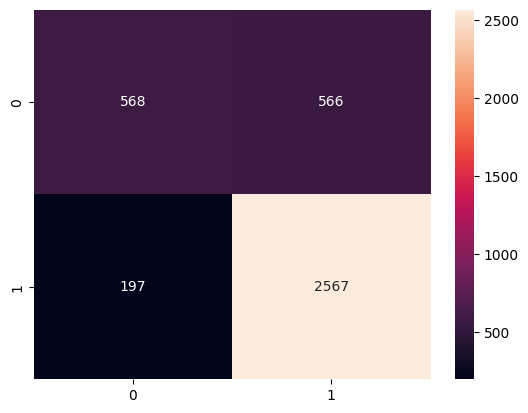

In [32]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred_multinomial_basico), annot=True, fmt= 'd')


In [33]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.metrics import precision_recall_fscore_support, accuracy_score,confusion_matrix

In [34]:
y_predproba_multinomial_basico = multinomial_basico.predict_proba(X_test_vec)
y_predproba_tdf_con_stopwords = tdf_con_stopwords.predict_proba(X_test_tfidf_stops)
y_predproba_tdf_con_trigramas = tdf_con_trigramas.predict_proba(X_test_tfidf_trigrama)

In [36]:
print (classification_report(y_test, y_pred_multinomial_basico))
@interact(punto_corte=(0, 1, 0.01), model=['MNNB', 'Tri', 'Stop'])

def funcion(model, punto_corte=0.5):
    if model == 'MNNB':
        sel_model = y_predproba_multinomial_basico
    elif model == 'Tri':
        sel_model = y_predproba_tdf_con_trigramas
    else:
        sel_model = y_predproba_tdf_con_stopwords
    
    y_pred = np.where(sel_model > punto_corte, 1, 0)
    conf_mat = pd.crosstab(y_test, y_pred[:,1], rownames = ['Actual'], colnames = ['Predicted'])
    sns.heatmap(conf_mat, annot=True, fmt='g')
    
    res = precision_recall_fscore_support(y_test, y_pred[:,1], average = 'binary')
    
    print("\nPrecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % (res[0], res[1], res[2], accuracy_score(y_test, y_pred[:,1])))


              precision    recall  f1-score   support

           0       0.74      0.50      0.60      1134
           1       0.82      0.93      0.87      2764

    accuracy                           0.80      3898
   macro avg       0.78      0.71      0.73      3898
weighted avg       0.80      0.80      0.79      3898



interactive(children=(Dropdown(description='model', options=('MNNB', 'Tri', 'Stop'), value='MNNB'), FloatSlide…

: 

: 

In [35]:
#Pequeña prueba
classes={0:'negativo',1:'positivo'};
#Hay que incluir un preprocesador que le pase todo el strip, lower, acentos, etc. Lo pusimos en un pickle para el streamlit
texto_prueba= "Lo malo de conocer la cerveza Patagonia es que después ninguna te parece suficiente"
stem_prueba = stemfraseesp(texto_prueba)
dato = [stem_prueba]
texto_vec=X_tfidf_trigrama_vec.transform(dato);
clase=tdf_con_trigramas.predict_proba(texto_vec)[:,0]>=0.3

print('Comentario:',texto_prueba,'\n')

if clase == True:
    print("Negativo")
else:
        print("Positivo")

Comentario: Lo malo de conocer la cerveza Patagonia es que después ninguna te parece suficiente 

Positivo


In [36]:
#Generamos gráficos de palabras en los comentarios positivos y negativos
posit=datafinal[datafinal.target==1]
negat=datafinal[datafinal.target==0]

print(posit.shape)
print(negat.shape)

(11053, 11)
(4537, 11)


In [37]:
#Obtenemos la lista de textos tokenizados para cada clase
tokenized_texts_posit=[];
for t in posit['matches'].tolist():
     tokens=word_tokenize(t);
     tokens_without_stopwords=[tok for tok in tokens if not (tok in stopwords)]; # Creamos una lista de tokens que no pertenecen a la lista de stopwords
     #print(tokens_without_stopwords)
     tokenized_texts_posit.append(tokens_without_stopwords);

vocabulario_posit=sorted([tok for tokens in tokenized_texts_posit for tok in tokens]);
#print(vocabulario_posit)

tokenized_texts_negat=[];
for t in negat['matches'].tolist():
     tokens=word_tokenize(t);
     tokens_without_stopwords=[tok for tok in tokens if not (tok in stopwords)]; # Creamos una lista de tokens que no pertenecen a la lista de stopwords
     #print(tokens_without_stopwords)
     tokenized_texts_negat.append(tokens_without_stopwords);

vocabulario_negat=sorted([tok for tokens in tokenized_texts_negat for tok in tokens]);
#print(vocabulario_negat)

In [38]:
tokenized_texts_negat=[];
for t in negat['matches'].tolist():
     tokens=word_tokenize(t);
     tokens_without_stopwords=[tok for tok in tokens if not (tok in stopwords)]; # Creamos una lista de tokens que no pertenecen a la lista de stopwords
     #print(tokens_without_stopwords)
     tokenized_texts_negat.append(tokens_without_stopwords);

vocabulario_negat=sorted([tok for tokens in tokenized_texts_negat for tok in tokens]);
#print(vocabulario)

In [39]:
print("Cantidad de palabras positivas ", len(vocabulario_posit))
print('---------------------')
print("Cantidad de palabras negativas ", len(vocabulario_negat))

Cantidad de palabras positivas  52322
---------------------
Cantidad de palabras negativas  34287


In [40]:
#Traemos la librerias
from collections import Counter
# WordCloud instalarlo primero 
# conda install -c conda-forge wordcloud

#from wordcloud import WordCloud

In [41]:
counter_posit=Counter(vocabulario_posit)
counter_posit.most_common(30)

[('amber', 1179),
 ('lager', 902),
 ('si', 700),
 ('mejor', 580),
 ('quiero', 544),
 ('weise', 530),
 ('rica', 458),
 ('tomar', 331),
 ('ipa', 270),
 ('ganas', 267),
 ('buena', 264),
 ('bien', 261),
 ('vamos', 259),
 ('amigos', 221),
 ('mira', 212),
 ('abrazo', 198),
 ('oso', 194),
 ('dale', 191),
 ('seguir', 190),
 ('tomando', 187),
 ('gratis', 186),
 ('historia', 181),
 ('gana', 174),
 ('gusta', 174),
 ('sorteo', 172),
 ('rosario', 170),
 ('etiqueta', 169),
 ('cargo', 168),
 ('pasos', 167),
 ('segui', 167)]

In [42]:
counter_negat=Counter(vocabulario_negat)
counter_negat.most_common(50)

[('stella', 368),
 ('lager', 332),
 ('si', 312),
 ('amber', 247),
 ('cualquier', 214),
 ('hizo', 203),
 ('poder', 191),
 ('momento', 188),
 ('andes', 179),
 ('birras', 161),
 ('cosa', 157),
 ('vasos', 154),
 ('poner', 153),
 ('vender', 149),
 ('copa', 146),
 ('stock', 145),
 ('peso', 141),
 ('contexto', 140),
 ('consultar', 139),
 ('ganarme', 139),
 ('porrones', 139),
 ('viviendo', 139),
 ('ipa', 133),
 ('oso', 127),
 ('botella', 113),
 ('trigo', 107),
 ('origen', 105),
 ('tomar', 104),
 ('gusta', 100),
 ('corona', 98),
 ('mejor', 98),
 ('gusto', 96),
 ('judicial', 93),
 ('abrazo', 92),
 ('venden', 87),
 ('imperial', 85),
 ('levadura', 84),
 ('pagan', 84),
 ('quilmes', 84),
 ('hace', 83),
 ('solo', 82),
 ('asi', 81),
 ('dos', 81),
 ('heineken', 81),
 ('probe', 81),
 ('cuanto', 80),
 ('hoy', 80),
 ('ser', 80),
 ('puedo', 79),
 ('weise', 79)]

In [43]:
texto_posit=" ".join(vocabulario_posit)

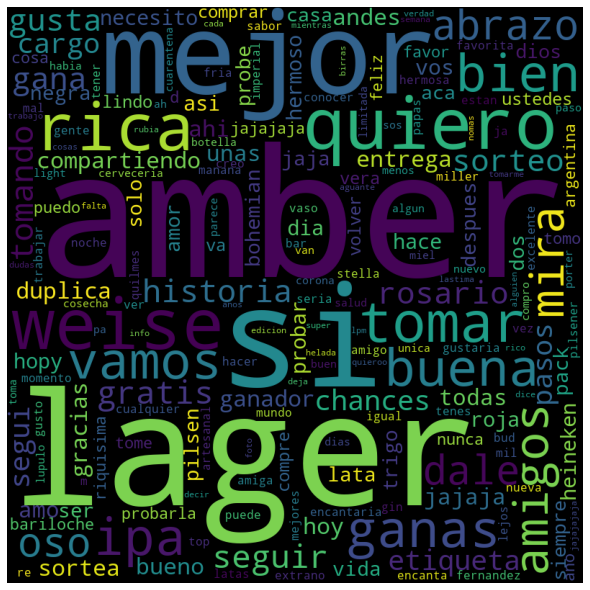

In [ ]:
#WordCloud is deprecated and unused for the app
# wordcloud =WordCloud(width=800, height=800).generate_from_frequencies(counter_posit) 
  
# # plot the WordCloud image                        
# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
# plt.show() 

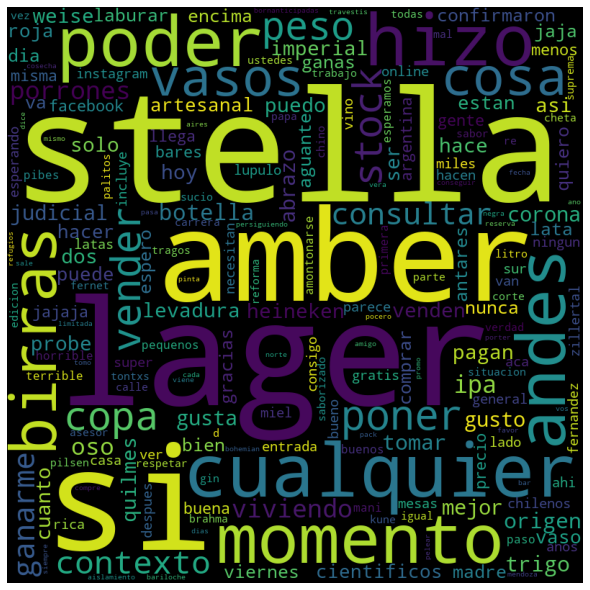

In [ ]:
# wordcloud =WordCloud(width=800, height=800).generate_from_frequencies(counter_negat) 
  
# # plot the WordCloud image                        
# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
# plt.show() 

In [44]:
import pickle
with open('modelo.pkl', 'wb') as modelo:
    pickle.dump(tdf_con_trigramas, modelo)
with open('vectorizer.pkl','wb') as vectorizador:
    pickle.dump(X_tfidf_trigrama_vec, vectorizador)